# Predicting NBA Players’ Playoff Performance

In [1]:
import pandas as pd
import requests
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression

## Webscrapes the NBA stats website and returns information for each player

In [2]:
def get_nba_data(start_year, end_year):
    
    """
    returns NBA player stats data for a given range of seasons

    args:
        start_year (int): starting season year in the format YYYY
        end_year (int): ending season year in the format YYYY

    returns:
        data_df (pandas.DataFrame): DataFrame containing NBA player stats data
    """

    season_types =['Regular%20Season', 'Playoffs']
    test_url = 'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season=2012-13&SeasonType=Regular%20Season&StatCategory=PTS'
    r = requests.get(url=test_url).json()
    table_headers = r['resultSet']['headers']
    df_cols = ['Year', 'Season_type'] + table_headers
    df = pd.DataFrame(columns=df_cols)
    
    years = [f'{year}-{str(year+1)[-2:]}' for year in range(start_year, end_year + 1)]

    for year in years:
        for season in season_types:
            api_url = f'https://stats.nba.com/stats/leagueLeaders?LeagueID=00&PerMode=PerGame&Scope=S&Season={year}&SeasonType={season}&StatCategory=PTS'
            r = requests.get(url=api_url).json()
            temp_df1 = pd.DataFrame(r['resultSet']['rowSet'], columns=table_headers)
            temp_df2 = pd.DataFrame({'Year':[year for i in range(len(temp_df1))], 
                                    'Season_type':[season for i in range(len(temp_df1))]})
            temp_df3 = pd.concat([temp_df2, temp_df1], axis=1)
            df = pd.concat([df, temp_df3], axis=0)
    return df

get_nba_data(2012, 2020)

,Year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF
0,2012-13,Regular%20Season,2546,1,Carmelo Anthony,1610612752,NYK,67,37.0,10.0,...,0.830,2.0,4.9,6.9,2.6,0.8,0.5,2.6,28.7,23.2
1,2012-13,Regular%20Season,201142,2,Kevin Durant,1610612760,OKC,81,38.5,9.0,...,0.905,0.6,7.3,7.9,4.6,1.4,1.3,3.5,28.1,30.4
2,2012-13,Regular%20Season,977,3,Kobe Bryant,1610612747,LAL,78,38.6,9.5,...,0.839,0.8,4.7,5.6,6.0,1.4,0.3,3.7,27.3,24.6
3,2012-13,Regular%20Season,2544,4,LeBron James,1610612748,MIA,76,37.9,10.1,...,0.753,1.3,6.8,8.0,7.3,1.7,0.9,3.0,26.8,32.2
4,2012-13,Regular%20Season,201935,5,James Harden,1610612745,HOU,78,38.3,7.5,...,0.851,0.8,4.1,4.9,5.8,1.8,0.5,3.8,25.9,24.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,2020-21,Playoffs,203524,143,Solomon Hill,1610612737,ATL,14,10.4,0.4,...,0.500,0.2,1.1,1.4,0.2,0.1,0.1,0.1,1.2,1.5
143,2020-21,Playoffs,1627885,144,Shaquille Harrison,1610612743,DEN,9,4.4,0.3,...,0.667,0.0,0.9,0.9,0.3,0.3,0.3,0.6,1.0,2.1
144,2020-21,Playoffs,1630264,145,Anthony Gill,1610612764,WAS,4,8.3,0.0,...,0.000,0.3,0.8,1.0,0.0,0.0,0.0,0.8,0.0,-0.5
145,2020-21,Playoffs,1629067,145,Isaac Bonga,1610612764,WAS,4,2.5,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,-1.0


## Filters the dataframe to only include players who played in both the regular season and playoffs

In [3]:
def filter_nba_data(df):
    """
    Returns NBA player stats data filtered to only include players who played in both the regular season and playoffs in the same season
    Args:
       df (pandas.DataFrame): DataFrame containing NBA player stats data
    Returns:
       filtered_df (pandas.DataFrame): DataFrame containing filtered NBA player stats data
    """

    # Create a set of unique player IDs who played in the regular season and playoffs for the same season
    players_both_seasons = set(df[(df['Season_type'] == 'Regular%20Season') & df['PLAYER_ID'].isin(df[df['Season_type'] == 'Playoffs']['PLAYER_ID'])]['PLAYER_ID'])
    
    # Replaces Regular%20Season with Regular seaosn for the Season_type feature
    df['Season_type'] = df['Season_type'].replace('Regular%20Season', 'Regular Season')

    # Filter rows where players have played in both regular season and playoffs for the same season
    filtered_df = df[df['PLAYER_ID'].isin(players_both_seasons)]

    return filtered_df



data = get_nba_data(2012, 2020)
filtered_data = filter_nba_data(data)
filtered_data

,Year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,GP,MIN,FGM,...,FT_PCT,OREB,DREB,REB,AST,STL,BLK,TOV,PTS,EFF
0,2012-13,Regular Season,2546,1,Carmelo Anthony,1610612752,NYK,67,37.0,10.0,...,0.830,2.0,4.9,6.9,2.6,0.8,0.5,2.6,28.7,23.2
1,2012-13,Regular Season,201142,2,Kevin Durant,1610612760,OKC,81,38.5,9.0,...,0.905,0.6,7.3,7.9,4.6,1.4,1.3,3.5,28.1,30.4
3,2012-13,Regular Season,2544,4,LeBron James,1610612748,MIA,76,37.9,10.1,...,0.753,1.3,6.8,8.0,7.3,1.7,0.9,3.0,26.8,32.2
4,2012-13,Regular Season,201935,5,James Harden,1610612745,HOU,78,38.3,7.5,...,0.851,0.8,4.1,4.9,5.8,1.8,0.5,3.8,25.9,24.0
5,2012-13,Regular Season,201566,6,Russell Westbrook,1610612760,OKC,82,34.9,8.2,...,0.800,1.4,3.9,5.2,7.4,1.8,0.3,3.3,23.2,22.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,2020-21,Playoffs,1626178,140,Rondae Hollis-Jefferson,1610612757,POR,5,7.2,0.8,...,0.667,0.6,1.0,1.6,0.0,0.2,0.2,0.0,2.0,3.6
142,2020-21,Playoffs,203524,143,Solomon Hill,1610612737,ATL,14,10.4,0.4,...,0.500,0.2,1.1,1.4,0.2,0.1,0.1,0.1,1.2,1.5
143,2020-21,Playoffs,1627885,144,Shaquille Harrison,1610612743,DEN,9,4.4,0.3,...,0.667,0.0,0.9,0.9,0.3,0.3,0.3,0.6,1.0,2.1
145,2020-21,Playoffs,1629067,145,Isaac Bonga,1610612764,WAS,4,2.5,0.0,...,0.000,0.0,0.0,0.0,0.0,0.0,0.3,0.0,0.0,-1.0


## Updates the dataframe to include the ages of every player

In [4]:
def get_player_age(df):
    
    """
    returns an updated basketball_df with the players age on the season
    
    args:
        df(pandas.DataFrame): DataFrame containing NBA player stats data
    
    returns:
        updated_df: same dataframe but with age
    """

    df_csv = pd.read_csv('all_seasons.csv')
    result_df = pd.DataFrame(columns=['PLAYER', 'Year', 'Age'])
    for player_name, group in df.groupby('PLAYER'):

        # Find the row with the earliest year for the player
        earliest_year_row = group[group['Year'] == group['Year'].min()]
        player_name = earliest_year_row.iloc[0]['PLAYER']
        year = earliest_year_row.iloc[0]['Year']
        
        # Find the corresponding age in the df_csv DataFrame
        matching_data = df_csv[(df_csv['player_name'] == player_name) & (df_csv['season'] == year)]

        if not matching_data.empty:
            age = matching_data['age'].values[0]
            result_df = result_df.append({'PLAYER': player_name, 'Year': year, 'Age': age}, ignore_index=True)
            
    # Merge the age information back into the original df DataFrame
    updated_df = pd.merge(df, result_df, on=['PLAYER', 'Year'], how='left')
    return updated_df

df = get_player_age(filtered_data)

## Updates the dataframe to include those who have only played in the regular season and playoffs

In [5]:
def combine_df(df):
    """
    returns an updated basketball_df with players that have played in the regular and playoff season
   
    args:
        df(pandas.DataFrame): DataFrame containing NBA player stats data
   
    returns:
        merged_df: same dataframe but with specific players
    """
    # Seperating the data frame
    
    # Only regular season stats
    regular_df = df[['Year', 'Season_type', 'PLAYER_ID', 'RANK', 'PLAYER', 'TEAM_ID', 'TEAM', 'PTS']].copy()
    regular_df = regular_df[regular_df['Season_type'] != 'Playoffs']
   
    # Only playoff stats
    playoff_df = df[['Year', 'Season_type', 'PLAYER_ID', 'RANK', 'PLAYER', 'TEAM_ID', 'TEAM', 'PTS']].copy()
    playoff_df = playoff_df[playoff_df['Season_type'] != 'Regular Season']
   
    # Have players that are in the regualar matches and playoff matches in that season
    common_players = set(regular_df['PLAYER']).intersection(playoff_df['PLAYER'])
    regular_df = regular_df[regular_df['PLAYER'].isin(common_players)]
    playoff_df = playoff_df[playoff_df['PLAYER'].isin(common_players)]
   
    #merge two dfs
    regular_df = regular_df.sort_values(by='PLAYER')
    playoff_df = playoff_df.sort_values(by='PLAYER')
    merged_df = regular_df.merge(playoff_df, on='PLAYER', suffixes=('_RS', '_Playoff'))
   
    # adding the age
    merged_df['Age'] = merged_df['PLAYER'].map(df.drop_duplicates('PLAYER').set_index('PLAYER')['Age'])
    merged_df = merged_df.dropna(subset = ['Age'])
    return merged_df
 
final_df = combine_df(df)
final_df

,Year_RS,Season_type_RS,PLAYER_ID_RS,RANK_RS,PLAYER,TEAM_ID_RS,TEAM_RS,PTS_RS,Year_Playoff,Season_type_Playoff,PLAYER_ID_Playoff,RANK_Playoff,TEAM_ID_Playoff,TEAM_Playoff,PTS_Playoff,Age
0,2016-17,Regular Season,201166,246,Aaron Brooks,1610612754,IND,5.0,2012-13,Playoffs,201166,100,1610612745,HOU,5.0,28.0
1,2016-17,Regular Season,201166,246,Aaron Brooks,1610612754,IND,5.0,2014-15,Playoffs,201166,120,1610612741,CHI,4.5,28.0
2,2013-14,Regular Season,201166,157,Aaron Brooks,1610612743,DEN,9.0,2012-13,Playoffs,201166,100,1610612745,HOU,5.0,28.0
3,2013-14,Regular Season,201166,157,Aaron Brooks,1610612743,DEN,9.0,2014-15,Playoffs,201166,120,1610612741,CHI,4.5,28.0
4,2015-16,Regular Season,201166,191,Aaron Brooks,1610612741,CHI,7.1,2012-13,Playoffs,201166,100,1610612745,HOU,5.0,28.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5779,2016-17,Regular Season,2585,225,Zaza Pachulia,1610612744,GSW,6.1,2015-16,Playoffs,2585,96,1610612742,DAL,6.6,31.0
5780,2016-17,Regular Season,2585,225,Zaza Pachulia,1610612744,GSW,6.1,2016-17,Playoffs,2585,115,1610612744,GSW,5.1,31.0
5781,2018-19,Regular Season,2585,252,Zaza Pachulia,1610612765,DET,3.9,2014-15,Playoffs,2585,103,1610612749,MIL,6.7,31.0
5782,2018-19,Regular Season,2585,252,Zaza Pachulia,1610612765,DET,3.9,2015-16,Playoffs,2585,96,1610612742,DAL,6.6,31.0


In [6]:
RSPPG_fil_df = filtered_data[['Year', 'Season_type', 'PLAYER_ID', 'RANK', 'PLAYER', 'TEAM_ID', 'TEAM', 'PTS']].copy()

RSPPG_fil_df = RSPPG_fil_df[RSPPG_fil_df['Season_type'] != 'Playoffs']

RSPPG_fil_df.head()

,Year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,PTS
0,2012-13,Regular Season,2546,1,Carmelo Anthony,1610612752,NYK,28.7
1,2012-13,Regular Season,201142,2,Kevin Durant,1610612760,OKC,28.1
3,2012-13,Regular Season,2544,4,LeBron James,1610612748,MIA,26.8
4,2012-13,Regular Season,201935,5,James Harden,1610612745,HOU,25.9
5,2012-13,Regular Season,201566,6,Russell Westbrook,1610612760,OKC,23.2


In [7]:
PlayoffPPG_fil_df = filtered_data[['Year', 'Season_type', 'PLAYER_ID', 'RANK', 'PLAYER', 'TEAM_ID', 'TEAM', 'PTS']].copy()

PlayoffPPG_fil_df = PlayoffPPG_fil_df[PlayoffPPG_fil_df['Season_type'] != 'Regular Season']

PlayoffPPG_fil_df.head()

,Year,Season_type,PLAYER_ID,RANK,PLAYER,TEAM_ID,TEAM,PTS
0,2012-13,Playoffs,201142,1,Kevin Durant,1610612760,OKC,30.8
1,2012-13,Playoffs,2546,2,Carmelo Anthony,1610612752,NYK,28.8
2,2012-13,Playoffs,201935,3,James Harden,1610612745,HOU,26.3
3,2012-13,Playoffs,2544,4,LeBron James,1610612748,MIA,25.9
4,2012-13,Playoffs,201939,5,Stephen Curry,1610612744,GSW,23.4


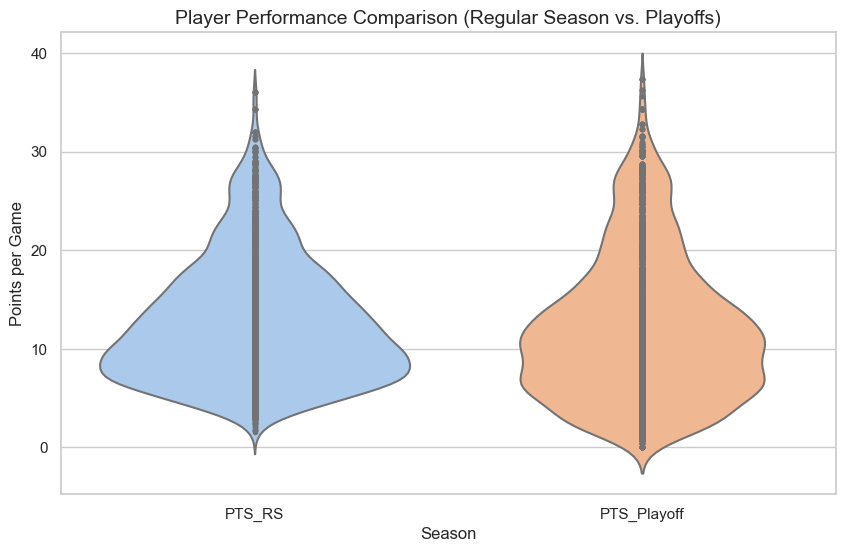

In [8]:
# Visualization 1: Player Performance Comparison
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
sns.violinplot(data=final_df[['PTS_RS', 'PTS_Playoff']], inner="points", palette="pastel")

# Set axis labels and title
plt.xlabel('Season', fontsize=12)
plt.ylabel('Points per Game', fontsize=12)
plt.title('Player Performance Comparison (Regular Season vs. Playoffs)', fontsize=14)


plt.show()

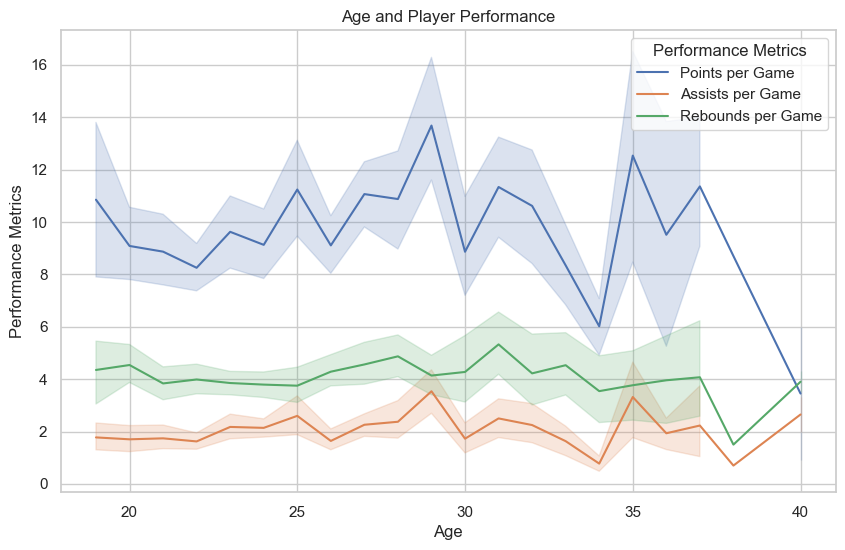

In [9]:
# Visualization 2: Age and Player Performance
plt.figure(figsize=(10, 6))
sns.lineplot(x='Age', y='PTS', data=df, label='Points per Game')
sns.lineplot(x='Age', y='AST', data=df, label='Assists per Game')
sns.lineplot(x='Age', y='REB', data=df, label='Rebounds per Game')
plt.xlabel('Age')
plt.ylabel('Performance Metrics')
plt.title('Age and Player Performance')
plt.legend(title='Performance Metrics')
plt.show()

## Plots a specific players performance as they get older

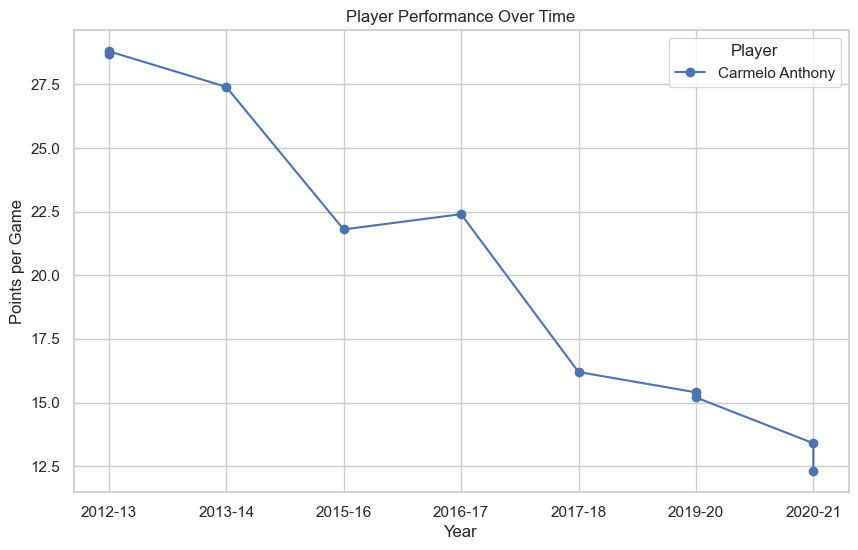

In [10]:
def plot_player_performance(player_id):
    # Filter data for the specific player_id
    player_data = filtered_data[filtered_data['PLAYER_ID'] == player_id]

    # Check if the player_id exists in the dataset
    if player_data.empty:
        print(f"Player with ID {player_id} not found in the dataset.")
        return

    plt.figure(figsize=(10, 6))
    plt.plot(player_data['Year'], player_data['PTS'], marker='o', label=player_data['PLAYER'].iloc[0])
    plt.xlabel('Year')
    plt.ylabel('Points per Game')
    plt.title('Player Performance Over Time')
    plt.legend(title='Player')
    plt.grid(True)
    plt.show()

plot_player_performance(2546)

In [11]:
pip install scikit-learn

Note: you may need to restart the kernel to use updated packages.


Mean Squared Error: 23.333797077056744
R-squared: 0.5429293946838474


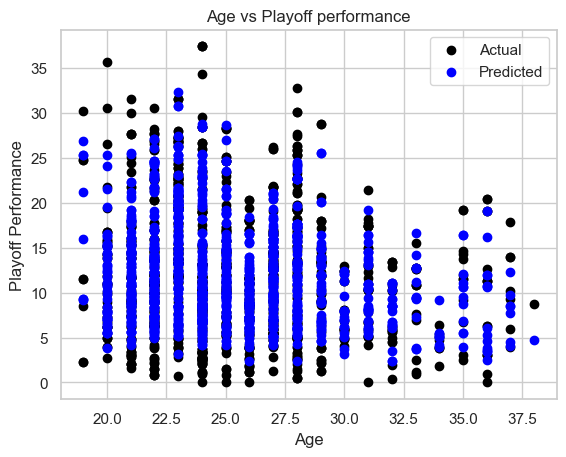

In [12]:
# Select relevant features
features = ['PTS_RS', 'Age']

# Define the target variable
target = 'PTS_Playoff'

# Create feature matrix (X) and target vector (y)
X = final_df[features]
y = final_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Visualize the results
plt.scatter(X_test['Age'], y_test, color='black', label='Actual')
plt.scatter(X_test['Age'], predictions, color='blue', label='Predicted')
plt.xlabel('Age')
plt.ylabel('Playoff Performance')
plt.title('Age vs Playoff performance')
plt.legend()
plt.show()

Mean Squared Error (Cross-Validated): 23.968075044508417
R-squared (Cross-Validated): 0.5540884055564311


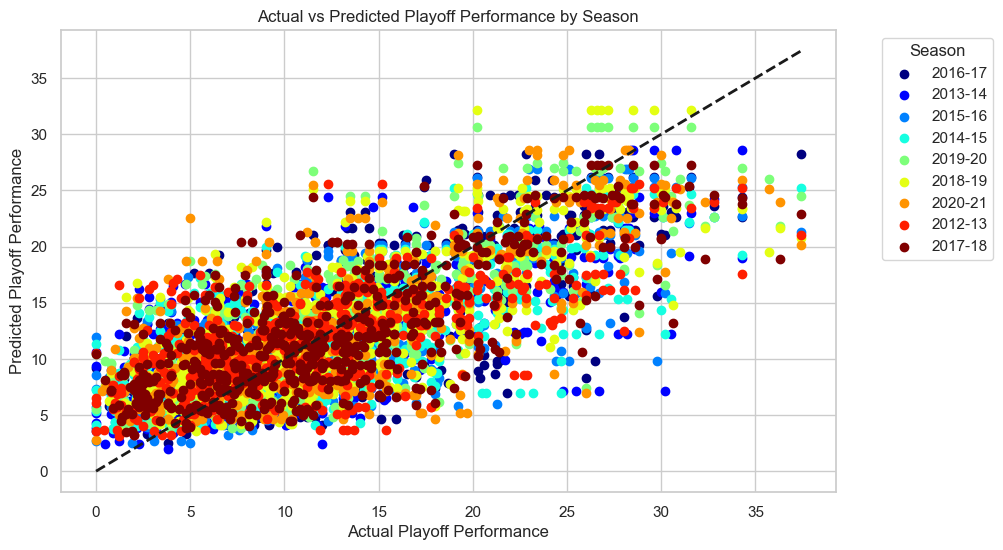

In [13]:
from sklearn.model_selection import train_test_split, KFold, cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np


features = ['PTS_RS', 'Age']

# Define the target variable
target = 'PTS_Playoff'

# Create feature matrix (X) and target vector (y)
X = final_df[features]
y = final_df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a linear regression model
model = LinearRegression()

# Fit the model with the entire dataset
model.fit(X, y)

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# Use cross_val_predict to get predictions during cross-validation
cv_predictions = cross_val_predict(model, X, y, cv=kf)

# Evaluate the model
mse = mean_squared_error(y, cv_predictions)
r2 = r2_score(y, cv_predictions)

print(f'Mean Squared Error (Cross-Validated): {mse}')
print(f'R-squared (Cross-Validated): {r2}')

# Visualization with different colors for each season
years = final_df['Year_RS'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(years)))

plt.figure(figsize=(10, 6))

for i, year in enumerate(years):
    year_data = final_df[final_df['Year_RS'] == year]
    X_year = year_data[features]
    y_year = year_data[target]
    predictions_year = model.predict(X_year)

    plt.scatter(y_year, predictions_year, color=colors[i], label=year)

plt.plot([y.min(), y.max()], [y.min(), y.max()], '--k', lw=2)
plt.xlabel('Actual Playoff Performance')
plt.ylabel('Predicted Playoff Performance')
plt.title('Actual vs Predicted Playoff Performance by Season')
plt.legend(title='Season', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()


Mean Squared Error (Cross-Validated) for 2020-21: 27.84094611738039
R-squared (Cross-Validated) for 2020-21: 0.5312962779561159


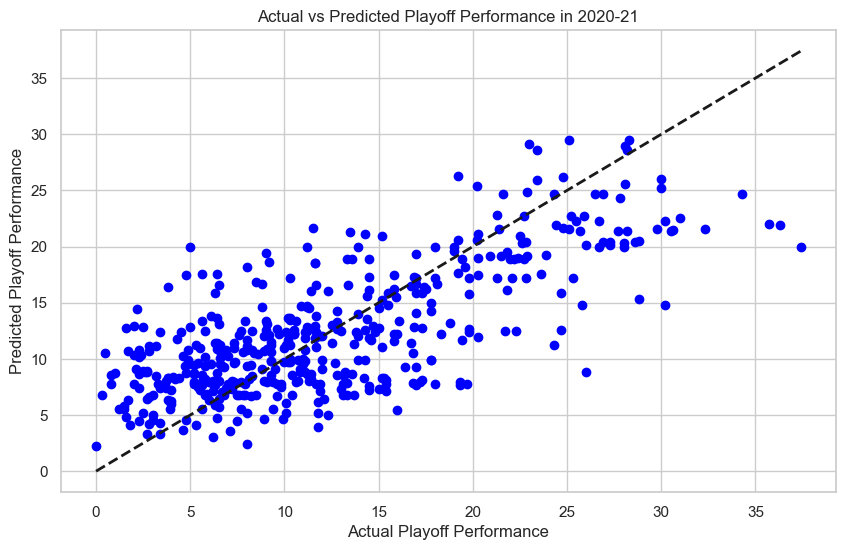

In [17]:
# Choose the specific year
specific_year = '2020-21'

# Filter the data for the specific year
year_data = final_df[final_df['Year_RS'] == specific_year]
X_year = year_data[features]
y_year = year_data[target]

# Create and fit a linear regression model
model = LinearRegression()
model.fit(X_year, y_year)

# Perform k-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
cv_predictions = cross_val_predict(model, X_year, y_year, cv=kf)

# Evaluate the model
mse = mean_squared_error(y_year, cv_predictions)
r2 = r2_score(y_year, cv_predictions)

print(f'Mean Squared Error (Cross-Validated) for {specific_year}: {mse}')
print(f'R-squared (Cross-Validated) for {specific_year}: {r2}')

# Visualize the results for the specific year
plt.figure(figsize=(10, 6))
plt.scatter(y_year, cv_predictions, color='blue')
plt.plot([y_year.min(), y_year.max()], [y_year.min(), y_year.max()], '--k', lw=2)
plt.xlabel('Actual Playoff Performance')
plt.ylabel('Predicted Playoff Performance')
plt.title(f'Actual vs Predicted Playoff Performance in {specific_year}')
plt.show()
